In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from image_LaneDetect import LaneDetect

In [56]:
image_link = "./photo/lane_image.png" # .. : 상위 폴더, . : 현재 폴더
img =cv2.imread(image_link, cv2.IMREAD_ANYCOLOR)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [57]:
# HSV
cv2.imshow("HSV Image", img_hsv)
cv2.waitKey()
cv2.destroyAllWindows()

In [58]:
# Sobel 필터 : 이미지 경계를 검출하기 위해 사용되는 필터

dx = 0
dy = 1
img_sobel = cv2.Sobel(img, -1, dx, dy, delta=0)

cv2.imshow("Sobel Image", img_sobel)
cv2.waitKey()
cv2.destroyAllWindows()

In [59]:
# bird view : 이미를 왜곡시켜 마치 도로면과 평행한

# 이미지의 형태 값을 저장
imshape = img_sobel.shape

# 높이와 폭을 저장
width = imshape[1]
height = imshape[0]

# pts1의 좌표 지정
pts1 = np.float32([[width*4/10, height*6/10], [width*3/20, height - 100], [width*6.5/10, height*6/10], [width*9/10, height - 100]])

# pts2의 좌표 지정
pts2 = np.float32([[0, 0], [0, height],[width*9/10, 0], [width, height]])

# pts1 -> pts2로 벼노한하는 변환행렬 추출
M = cv2.getPerspectiveTransform(pts1, pts2)

# 변환 행렬을 적용하여 왜곡
img_brid = cv2.warpPerspective(img_sobel, M, (width, 1000))

# 필요하다면 h, s, v 채널 값들을 각각 분리해서
h, s, v = cv2.split(img_brid)

# 필요한 채널 값들만 다시 포함시킬 수 있다. (이 코드는 원래의 이미지로 복구시킴)
img_bird = cv2.merge((h, s, v))

cv2.imshow("Bird View Image", img_bird)
cv2.waitKey()
cv2.destroyAllWindows()

In [60]:
# inRange 함수로, 이미지의 색상 범위를 좁히자

# low_white 및 high_white BGR 범위 설정
low_white = np.array([150, 100, 100], dtype="uint8")
high_white = np.array([180, 160, 250], dtype="uint8")

# low_yellow 및 high_yellow BGR 범위 설정
low_yellow = np.array([0, 0, 100], dtype="uint8")
high_yellow = np.array([70, 150, 250], dtype="uint8")

# inRange로 범위에 맞는 픽셀 검출
dst_white = cv2.inRange(img_bird, low_white, high_white)
dst_yellow = cv2.inRange(img_bird, low_yellow, high_yellow)

# 두 마스크를 결합
dst = cv2.add(dst_white, dst_yellow)

# 결과 이미지 출력
cv2.imshow("InRange Image", dst)
cv2.waitKey()
cv2.destroyAllWindows()


In [61]:
# Canny
img_canny = cv2.Canny(dst, 5000, 1500, apertureSize=7, L2gradient= True)

cv2.imshow("Canny Image", img_canny)
cv2.waitKey()
cv2.destroyAllWindows()

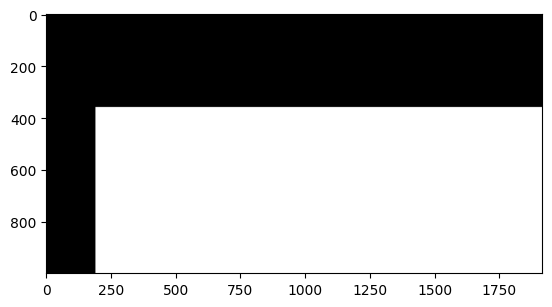

In [62]:
# img_canny와 같은 형태의 흑색 밑바탕
mask = np.zeros_like(img_canny)
# ROI 범위 지정
vertices = np.array([[(width/10, height),
                        (width/10,height/3),
                        (width,height/3),
                        (width, height)]], dtype=np.int32)

# 3차원 이상의 n차원 색상 모델인 경우 흰색 색상으로 지정
if len(img.shape) > 2:
    channel_count = img.shape[2]
    ignore_mask_color = (255, ) * channel_count # 3차원인 경우 (255, 255, 255)
else:
    ignore_mask_color = 255

# mask에 ROI 영역을 흰색으로 덮음
cv2.fillPoly(mask, vertices, ignore_mask_color)
plt.imshow(mask, cmap="gray")


In [63]:
# img_canny와 mask의 공통된 부분을 검출
masked_image = cv2.bitwise_and(img_canny, mask)

cv2.imshow("Masked Image", masked_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [64]:
# 윤곽선 그리기

contours, h = cv2.findContours(masked_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

color = [155, 155, 155] # 회색
for i, contour in enumerate(contours):
    cv2.drawContours(masked_image, [contour], -1, (100, 30, 10), thickness=3)
    # (컨투어 그릴 이미지, 컨투어 리스트, 인덱스, 색상, 두께)=

cv2.imshow("Contours", masked_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [65]:
# 허프라인 함수에 필요한 속성값들
rho = 1.0
theta = np.pi/180
threshold = 100
min_line_len = 30
max_line_gap = 80

lines = cv2.HoughLinesP(masked_image, rho, theta, threshold,
minLineLength=min_line_len, maxLineGap=max_line_gap)
img = np.zeros_like(masked_image, dtype=np.uint8)

# 평균 x, y 좌표를 저장할 리스트 초기화. 각 선의 중간점 좌표를 저장하기 위한 리스트
avg_x = []
avg_y = []
# 만약 허프 변환을 통해 선이 검출되었다면
if lines is not None:
 
 # 검출된 선들에 대해 반복
 for line in lines:
 # 각 선의 시작점과 끝점 좌표 가져오기
    for x1, y1, x2, y2 in line:
 # 두 점 사이의 기울기 계산
        ratio = (y2 - y1) / (x2 - x1)
 
        # x축 방향으로의 변화량이 0인 경우는 수직선이므로 패스 (나누기 0 회피)
        if (x2 - x1) == 0:
            pass
        
        # 기울기가 1보다 크거나 -1보다 작은 경우 (즉, 거의 수직에 가까운 선일 경우)
        elif ratio > 1 or ratio < -1:
            # 그 선을 이미지에 그림
            cv2.line(img, (x1, y1), (x2, y2), color, thickness=3)
            # 선의 중간 좌표 계산
            avg_x_val = (x1 + x2) / 2
            avg_y_val = (y1 + y2) / 2
            # 중간 좌표를 리스트에 추가
            avg_x.append(avg_x_val)
            avg_y.append(avg_y_val)
        
        # 기울기로부터 계산된 각도가 10도 미만인 경우 패스
        elif np.arccos(ratio) < 10:
            pass
        
        # 그 외의 경우 (즉, 다른 기울기의 선들)
        else:
        # 그 선을 이미지에 그림
            cv2.line(img, (x1, y1), (x2, y2), color, thickness=3)
            # 선의 중간 좌표 계산
            avg_x_val = (x1 + x2) / 2
            avg_y_val = (y1 + y2) / 2
            # 중간 좌표를 리스트에 추가
            avg_x.append(avg_x_val)
            avg_y.append(avg_y_val)
# 허프 변환을 통해 검출된 선들만 그린 이미지를 화면에 표시
cv2.imshow("Contours", img)
cv2.waitKey() # 키 이벤트가 있을 때까지 창을 유지
cv2.destroyAllWindows() # 모든 창을 닫음


In [66]:
# 윈도우 슬라이딩

center_x = [] # 중앙값 초기화
img_zero = np.zeros_like(masked_image)
img = masked_image # 이미지를 grayscale로 변환
hist = np.sum(img[:, :], axis = 0) # 이미지의 픽셀값을 히스토그램으로 변환
out = np.dstack((img, img, img)) * 255 # 그레이스케일의 단일채널을 3채널로 변환
mid = int(hist.shape[0] / 2) # 히스토그램의 중심점 설정
left_x = np.argmax(hist[:mid]) # 왼쪽 부분에서 히스토그램이 최댓값이 되는 x값을 찾고
right_x = np.argmax(hist[mid:]) + mid # 오른쪽 부분에서 히스토그램이 최댓값이 되는 x값을 찾고
num_window = 20 # 윈도우의 갯수 설정
window_h = int(img.shape[0] / num_window) # 윈도우의 높이는 이미지의 높이/윈도우의 갯수
nonzero = img.nonzero() # 이미지에서 픽셀값이 0이 아닌 좌표를 기록
nonzero_y = np.array(nonzero[0]) # 그 좌표중에 y값
nonzero_x = np.array(nonzero[1]) # 그 좌표중에 x값
now_left_x = left_x
now_right_x = right_x
min_pixel = 60 # 노이즈를 필터링하기 위한 윈도우내의 최소 픽셀갯수 기준
window_width = 20 # 윈도우의 가로 길이
win_left_lane = []
win_right_lane = []
for window in range(num_window):
 win_y_low = img.shape[0] - (window + 1) * window_h
 win_y_high = img.shape[0] - window * window_h
 win_left_xmin = now_left_x - window_width
 win_left_xmax = now_left_x + window_width
 win_right_xmin = now_right_x - window_width
 win_right_xmax = now_right_x + window_width


 cv2.rectangle(out, (win_left_xmin, win_y_low), (win_left_xmax, win_y_high), (0,255, 0), 2)
 cv2.rectangle(out, (win_right_xmin, win_y_low), (win_right_xmax, win_y_high), (0,255, 0), 2)
 left_window_idx = ((nonzero_y >= win_y_low) & (nonzero_y <= win_y_high) &(nonzero_x >= win_left_xmin) & 
                    (nonzero_x <= win_left_xmax)).nonzero()[0]
 right_window_idx = ((nonzero_y >= win_y_low) & (nonzero_y <= win_y_high) & (nonzero_x >= win_right_xmin) & 
                     (nonzero_x <= win_right_xmax)).nonzero()[0]
 
 # Append these indices to the lists
 win_left_lane.append(left_window_idx)
 win_right_lane.append(right_window_idx)
 # If you found > minpix pixels, recenter next window on their mean position
 if len(left_window_idx) > min_pixel:
    now_left_x = int(np.mean(nonzero_x[left_window_idx]))
 if len(right_window_idx) > min_pixel:
    now_right_x = int(np.mean(nonzero_x[right_window_idx]))

win_left_lane = np.concatenate(win_left_lane)
win_right_lane = np.concatenate(win_right_lane)
# Extract left and right line pixel positions
left_x, left_y = nonzero_x[win_left_lane], nonzero_y[win_left_lane]
right_x, right_y = nonzero_x[win_right_lane], nonzero_y[win_right_lane]
if len(left_x) > len(right_x):
    center_x = [(x + y)/2 for x, y in zip(left_x[:len(right_x)-1], right_x)]
elif len(left_x) < len(right_x):
    center_x = [(x + y)/2 for x, y in zip(right_x[:len(right_x)-1], left_x)]

out = cv2.resize(out, (800, 500))

cv2.imshow("Contours", out)
cv2.waitKey()
cv2.destroyAllWindows()

In [67]:
# 다항식 계산

if len(left_y) != 0 and len(left_x) != 0:
    left_fit = np.polyfit(left_y, left_x, 3)
else:
    left_fit = []
if len(right_y) != 0 and len(right_x) != 0:
    right_fit = np.polyfit(right_y, right_x, 3)
else:
    right_fit = []
left_fit = np.array(left_fit, dtype=np.float32)
right_fit = np.array(right_fit, dtype=np.float32)
if len(left_fit) == 0 or len(right_fit) == 0:
    if len(left_fit) == 0:
        left_fit = []
    elif len(right_fit) == 0:
        right_fit = []
    else:
        left_fit, right_fit = []
else:
    pass
print("left_fit = ", left_fit)
print("right_fit = ", right_fit)

left_fit =  [ 8.5116653e-08 -1.7251726e-04  4.4441916e-02  3.8125607e+02]
right_fit =  [ 3.9050232e-05 -5.1287677e-02  2.2235039e+01 -1.5947529e+03]


In [69]:
# 차선 인식 여부 반환

left_detect = 0 # 왼쪽 차선이 detect 되면 1, 안되면 0
right_detect = 0 # 오른쪽 차선이 detect 되면 1, 안되면 0
out_text = out.copy()
if len(left_x) != 0 and len(right_x) != 0 and len(left_y) != 0 and len(right_y) != 0 :
    cv2.putText(out_text, "Left lane is detecting",(100, 100),
    cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), thickness=2)
    cv2.putText(out_text, "Right lane is detecting",(1000, 100),
    cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), thickness=2)

    left_detect = 1
    right_detect = 1
    # print("left_fit = \\n",left_fit)
    # print("right_fit = \\n",right_fit)
    # print("left_fit[0] = \\n",type(left_fit[0]))
    # print("\\n")
else:
    if len(right_x) == 0 or len(right_y) == 0:
        cv2.putText(out_text, "Left lane is detecting",(100, 100),
        cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), thickness=2)
        left_detect = 1
        right_detect = 0
    elif len(left_x) == 0 or len(left_y) == 0:
        cv2.putText(out_text, "Right lane is detecting",(1400, 100),
        cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), thickness=2)
        left_detect = 0
        right_detect = 1
    else:
        left_detect = 0
        right_detect = 0
    pass
print("left lane condition is", left_detect)
print("right lane condition is", right_detect)
cv2.imshow("Final Image", out_text)
cv2.waitKey()
cv2.destroyAllWindows()

left lane condition is 1
right lane condition is 1


In [70]:
from movie_LaneDetect import LaneDetect
import cv2
lane_detect = LaneDetect()
movie_link = "../movie/lane.mp4"
cap = cv2.VideoCapture(movie_link)
if cap.isOpened():
    while True:
        ret, frame = cap.read()
        out, left_fit, right_fit, left_detect, right_detect = lane_detect.CvImage(frame)
        print("\n left_fit = ", left_fit)
        print("\n right_fit = ", right_fit)
        cv2.imshow("lane detect",out)
        if not ret:
            print("No movie")
            break
        if cv2.waitKey(40) == ord("q"):
            break
cap.release()
cv2.destroyAllWindows()
print("right_detect condition is", right_detect)
print("\n left_detect condition is", left_detect)
print("\n left_fit = ", left_fit)
print("\n right_fit = ", right_fit)

right_detect condition is 1

 left_detect condition is 1

 left_fit =  [ 8.5116653e-08 -1.7251726e-04  4.4441916e-02  3.8125607e+02]

 right_fit =  [ 3.9050232e-05 -5.1287677e-02  2.2235039e+01 -1.5947529e+03]
